# Benchmark Performance Comparison Across Different Environments

This notebook documents the process and results of comparing benchmark performance metrics collected from various computing environments. The analysis includes data aggregation, visualization, and interpretation to highlight differences and trends across machines.

### General functions:

In [1]:
import subprocess
import os
import tempfile
import pandas as pd
import matplotlib.pyplot as plt

def get_dataframe_from_ssh(hosts, locations):

    bench_csv = tempfile.mkdtemp(prefix="bench_csv_")

    all_dfs = []
    for host, location in zip(hosts, locations):
        if host:  # If host is not empty, use scp to copy from remote
            remote_path = f"{host}:{location}"
            try:
                subprocess.run(["scp", remote_path, bench_csv], check=True)
            except subprocess.CalledProcessError as e:
                print(f"Error copying from {remote_path}: {e}")
                continue
        else:  # Local file copy
            local_path = os.path.expanduser(location)
            try:
                subprocess.run(["cp", local_path, bench_csv], check=True)
            except subprocess.CalledProcessError as e:
                print(f"Error copying from {local_path}: {e}")
                continue

        filename = os.path.basename(location)
        file_path = os.path.join(bench_csv, filename)
        if os.path.exists(file_path):
            df = pd.read_csv(file_path)
            df["machine"] = host if host else "local"
            all_dfs.append(df)

        os.remove(file_path)

    return pd.concat(all_dfs, ignore_index=True)

def plot_benchmark(combined_df, n_rows = 5):
    types = combined_df['type'].unique()
    machines = combined_df['machine'].unique()
    if len(types) < n_rows:
        n_rows = len(types)
    n_cols = len(types) // n_rows + (len(types) % n_rows > 0)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 5 * n_rows), sharex=True)
    axes = axes.flatten()

    if len(types) == 1:
        axes = [axes]

    for ax, t in zip(axes, types):
        for m in machines:
            subset = combined_df[(combined_df['type'] == t) & (combined_df['machine'] == m)]
            ax.scatter(subset['n_proc'], subset['elapsed_time'], label=m)
        ax.set_title(t)
        ax.set_xlabel('n_proc')
        ax.set_ylabel('elapsed_time')
        ax.legend(title='machine')

    return fig

## Compressor A

scp: G:/Thaler/RunningIn_semiSuperv/optuna_results_a.csv: No such file or directory


Error copying from liae_daniela:G:/Thaler/RunningIn_semiSuperv/optuna_results_a.csv: Command '['scp', 'liae_daniela:G:/Thaler/RunningIn_semiSuperv/optuna_results_a.csv', '/tmp/bench_csv_1c25h_4s']' returned non-zero exit status 1.


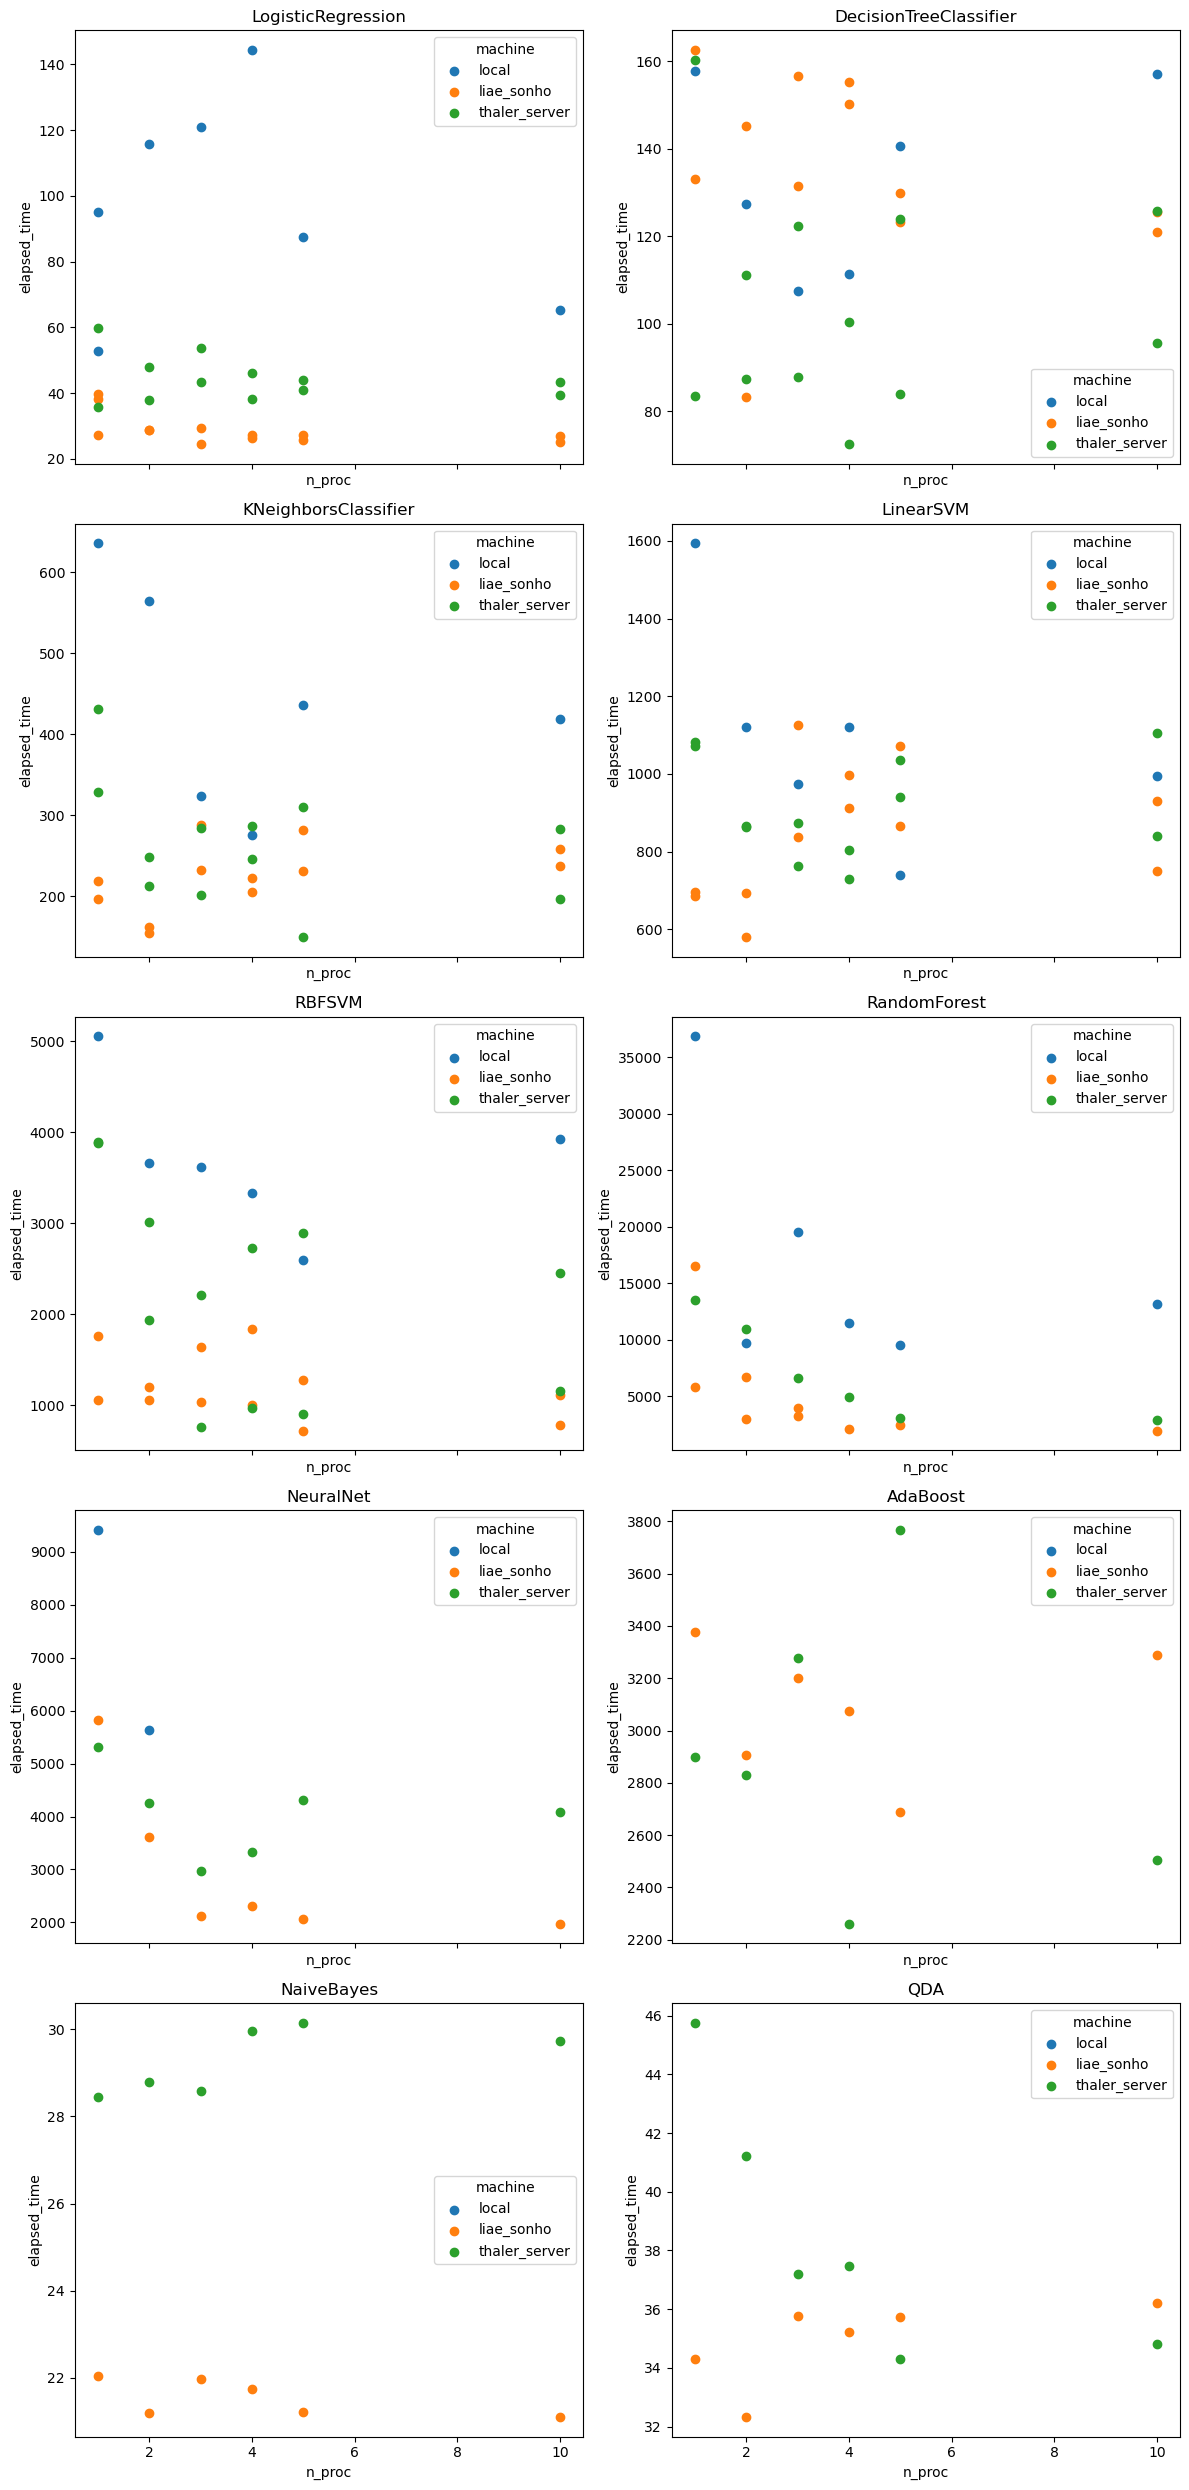

In [2]:
ssh_hosts = ["",
       "liae_sonho",
       "liae_daniela",
       "thaler_server"]

locations = [r"optuna_results_a.csv",
             r"~/LIAE/RunningIn_semiSuperv/optuna_results_a.csv",
             r"G:/Thaler/RunningIn_semiSuperv/optuna_results_a.csv",
             r"~/LIAE/RunningIn_semiSuperv/optuna_results_a.csv"]

data_bench_a = get_dataframe_from_ssh(ssh_hosts, locations)
fig = plot_benchmark(data_bench_a)
plt.tight_layout()
plt.show()

## Compressor B

cp: cannot stat 'optuna_results_b.csv': No such file or directory


Error copying from optuna_results_b.csv: Command '['cp', 'optuna_results_b.csv', '/tmp/bench_csv_ktx93fd2']' returned non-zero exit status 1.


scp: G:/Thaler/RunningIn_semiSuperv/optuna_results_b.csv: No such file or directory


Error copying from liae_daniela:G:/Thaler/RunningIn_semiSuperv/optuna_results_b.csv: Command '['scp', 'liae_daniela:G:/Thaler/RunningIn_semiSuperv/optuna_results_b.csv', '/tmp/bench_csv_ktx93fd2']' returned non-zero exit status 1.


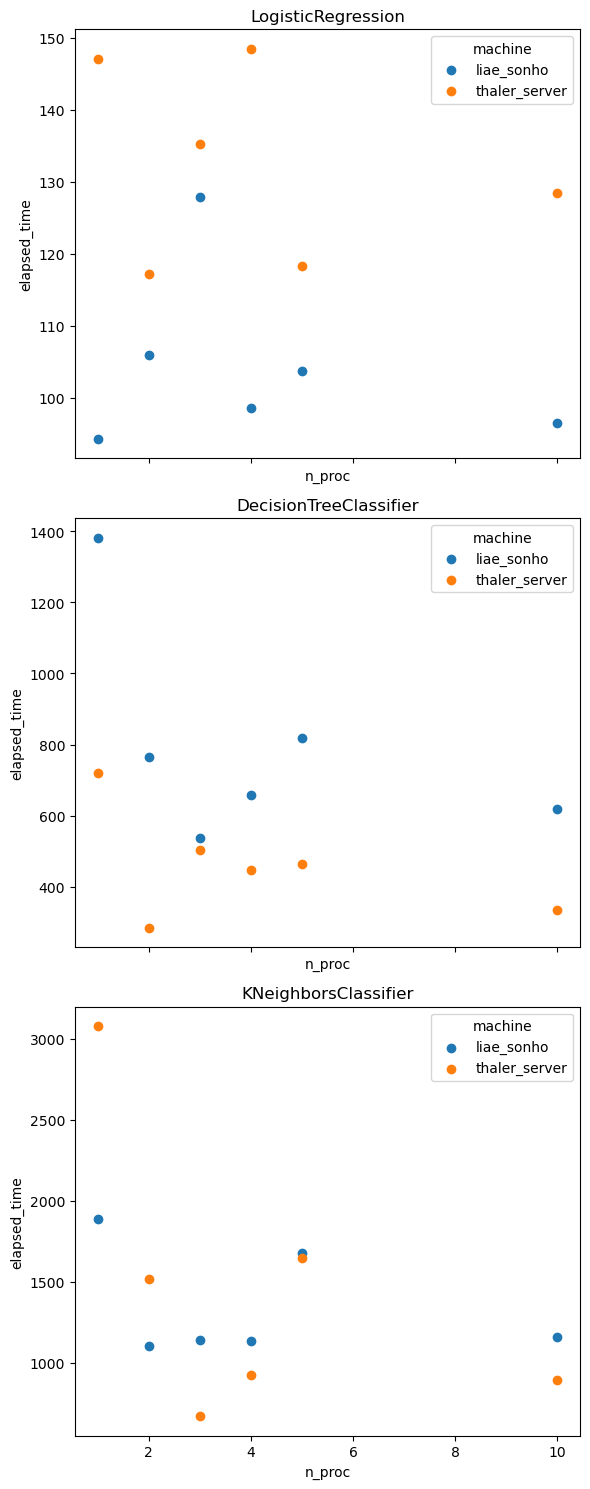

In [3]:
ssh_hosts = ["",
       "liae_sonho",
       "liae_daniela",
       "thaler_server"]

locations = [r"optuna_results_b.csv",
             r"~/LIAE/RunningIn_semiSuperv/optuna_results_b.csv",
             r"G:/Thaler/RunningIn_semiSuperv/optuna_results_b.csv",
             r"~/LIAE/RunningIn_semiSuperv/optuna_results_b.csv"]

data_bench_b = get_dataframe_from_ssh(ssh_hosts, locations)
fig = plot_benchmark(data_bench_b)
plt.tight_layout()
plt.show()

## All compressors

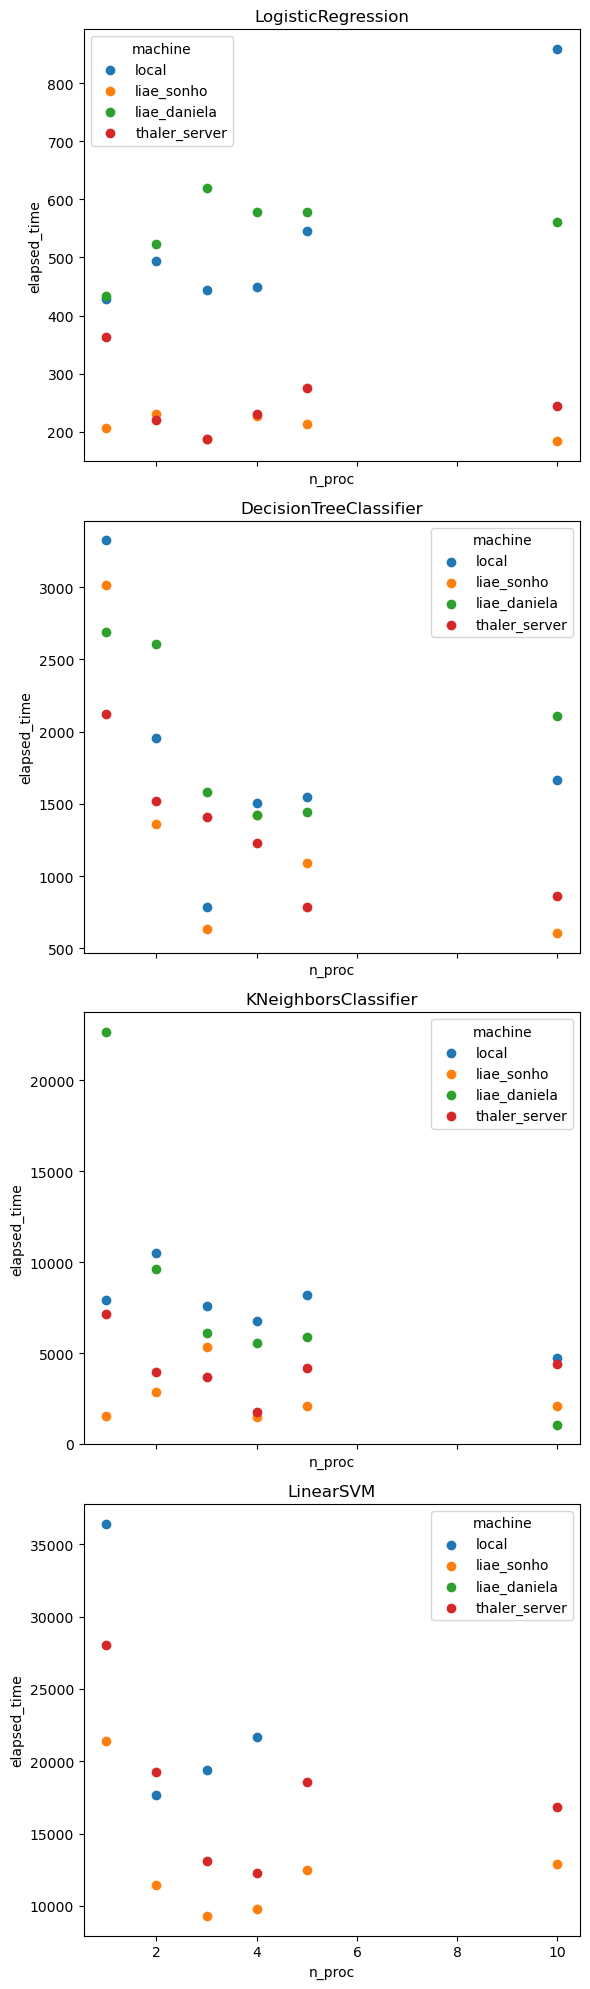

In [4]:
ssh_hosts = ["",
       "liae_sonho",
       "liae_daniela",
       "thaler_server"]

locations = [r"optuna_results_all.csv",
             r"~/LIAE/RunningIn_semiSuperv/optuna_results_all.csv",
             r"G:/Thaler/RunningIn_semiSuperv/optuna_results_all.csv",
             r"~/LIAE/RunningIn_semiSuperv/optuna_results_all.csv"]

data_bench_all = get_dataframe_from_ssh(ssh_hosts, locations)
fig = plot_benchmark(data_bench_all)
plt.tight_layout()
plt.show()

In [5]:
print(data_bench_all)

    n_proc  n_jobs  elapsed_time                type        machine
0        1       1    428.658957  LogisticRegression          local
1        2       1    493.071876  LogisticRegression          local
2        3       1    444.183084  LogisticRegression          local
3        4       1    448.695732  LogisticRegression          local
4        5       1    545.296678  LogisticRegression          local
..     ...     ...           ...                 ...            ...
83       2       1  19241.719548           LinearSVM  thaler_server
84       3       1  13067.999068           LinearSVM  thaler_server
85       4       1  12245.867607           LinearSVM  thaler_server
86       5       1  18541.707750           LinearSVM  thaler_server
87      10       1  16815.712014           LinearSVM  thaler_server

[88 rows x 5 columns]


In [ ]:
import optuna
import numpy as np


models = ["LogisticRegression",
    "DecisionTreeClassifier",
    "KNeighborsClassifier",
    "LinearSVM"
    ]

machines = ssh_hosts

db = data_bench_all
def objective(trial):
    machine = {"processes":[], "models":[], "elapsed_time":[]}
    machine_load = {k: machine for k in machines}
    longest_processes_time = np.zeros(len(models))
    for k in models:
        machine = trial.suggest_categorical(f"{k}_machine", machines)
        
        # Find the best n_proc for each (machine, model) combination based on lowest elapsed_time
        df_opt = db[(db['machine'] == machine) & (db['type'] == k)]
        if not df_opt.empty:
            best_row = df_opt.loc[df_opt['elapsed_time'].idxmin()]
            machine_load[machine]["models"].append(k)
            machine_load[machine]["processes"].append(int(best_row['n_proc']))
            machine_load[machine]["elapsed_time"].append(float(best_row['elapsed_time'])*1000)
        else:
            machine_load[machine]["models"].append(k)
            machine_load[machine]["processes"].append(1)
            machine_load[machine]["elapsed_time"].append(1e10)

        # Update the longest_processes_time for the current model
        longest_processes_time[models.index(k)] = max(longest_processes_time[models.index(k)], machine_load[machine]["elapsed_time"][-1])

    return np.sum(longest_processes_time)

study = optuna.create_study()
study.optimize(objective, n_trials=1000)
best_params = study.best_params
print(best_params)


[I 2025-08-19 18:44:38,225] A new study created in memory with name: no-name-c067253f-4c17-4d2a-ba1e-873e42c0207a
[I 2025-08-19 18:44:38,229] Trial 0 finished with value: 10003342783.895731 and parameters: {'LogisticRegression_machine': 'liae_sonho', 'DecisionTreeClassifier_machine': 'liae_daniela', 'KNeighborsClassifier_machine': 'thaler_server', 'LinearSVM_machine': ''}. Best is trial 0 with value: 10003342783.895731.
[I 2025-08-19 18:44:38,231] Trial 1 finished with value: 30000788978.768112 and parameters: {'LogisticRegression_machine': '', 'DecisionTreeClassifier_machine': 'thaler_server', 'KNeighborsClassifier_machine': '', 'LinearSVM_machine': 'liae_daniela'}. Best is trial 0 with value: 10003342783.895731.
[I 2025-08-19 18:44:38,232] Trial 2 finished with value: 30001067108.70719 and parameters: {'LogisticRegression_machine': '', 'DecisionTreeClassifier_machine': '', 'KNeighborsClassifier_machine': 'liae_daniela', 'LinearSVM_machine': ''}. Best is trial 0 with value: 1000334278

{'LogisticRegression_machine': 'liae_sonho', 'DecisionTreeClassifier_machine': 'liae_sonho', 'KNeighborsClassifier_machine': 'liae_daniela', 'LinearSVM_machine': 'liae_sonho'}
